

<hr style="margin-bottom: 40px;">

# Principal - Backtesting

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (A) (B) Simplified

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

df = pd.read_excel("Principal.xlsx", parse_dates=True, index_col="date")
df.apply(pd.to_numeric, errors='ignore')
df = df.rename(columns=lambda x: x.strip())
df = df.dropna(axis="index",how="all") #drop NaN values. The earliest data starts from 2001-11-20.
df = df.drop(["PRSSCOA HK Equity"],axis=1)

In [3]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return

In [4]:
describe = df.describe()
describe = pd.DataFrame(describe)
describe = describe.T
describe

,count,mean,std,min,25%,50%,75%,max
PRIAGSD HK Equity,1563.0,20.006846,2.112108,15.6100,18.160000,19.81000,21.940000,24.7500
PRIGLGC HK Equity,4801.0,16.644212,5.180473,7.4400,11.740000,17.18000,20.650000,26.5500
PRIHDSC HK Equity,4763.0,10.756074,0.300939,10.0390,10.383300,10.89080,10.937000,11.3056
PRILTAC HK Equity,4766.0,14.554230,3.491566,8.3228,11.042025,14.89255,17.333125,20.9627
PRILTGC HK Equity,4766.0,11.467751,1.366887,8.1355,10.296325,11.81295,12.709800,13.7850
PRICAPC HK Equity,4767.0,10.959695,0.402181,10.0980,10.450350,11.19940,11.229500,11.5160
PRASBON HK Equity,1798.0,9.981389,0.312778,9.4659,9.756450,9.90505,10.125125,10.9521
PRISTYC HK Equity,4766.0,14.457342,2.802819,9.4267,11.751625,14.97250,16.683100,19.5264


In [5]:
# get a list of all the column names 
indexNamesArr = describe.index.values
# convert ndarray to list
listOfRowIndexLabels = list(indexNamesArr)

coord = [(0.038802, 1.598254),( 0.023617, 0.745137),( 0.025753, 0.802417),( 0.045350, 2.066649),( 0.106415, 0.574546),( 0.053244, 0.432762),( 0.039204, 1.853161),( 0.059571, 0.444722),( 0.024976, 2.706996),( 0.012862, 0.312357),( 0.039587, 2.285998),( 0.001826, 0.044556),( 0.027979, 1.050875),( 0.032775, 1.438767),( 0.040590, 2.009521),( 0.042759, 2.400255)]
labels = listOfRowIndexLabels

def plot_with_labels(coord, labels):
    assert len(coord) == len(labels), 'coord len is not equal to labels len'
    plt.figure(figsize=(10,30))
    plt.xlabel('Mean historic return')
    plt.ylabel('volatility')
    plt.title("Performance of Principal Funds")
    plt
    for i, label in enumerate(labels): #get (0, label)
        x, y = coord[i] #2 dim
        plt.scatter(x, y,)
                #
        plt.annotate(label,
                xy=(x, y), #show point 
                xytext=(5, 2), #show annotate
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.show()
    
plot_with_labels(coord, labels)

AssertionError: coord len is not equal to labels len

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (C) - Backtesting and Optimization

### Split training set and test set

1. Split data in train and test set given a Date (i.e. test set is what happens after 31 July 2020 not included).

2. Further split train set into train set and validation set (i.e. what happens before 31 July 2020 included) in 6 consecutive time folds.

Then, in order not lo lose the time information, perform the following steps:
 
one = Train on fold 10,11,12,13 (2010-08-01 to 2014-07-31) –>  Test on fold 14 (2014-08-01 to 2015-07-31)

two = Train on fold 11,12,13,14 –>  Test on fold 15 

three = Train on fold 12,13,14,15 –>  Test on fold 16

four = Train on fold 13,14,15,16 –>  Test on fold 17

five = Train on fold 14,15,16,17 –>  Test on fold 18

six = Train on fold 15,16,17,18 –>  Test on fold 19 (2019-08-01 to 2020-07-31)

Compute the average of the accuracies of the 6 test folds.

In [8]:
S = CovarianceShrinkage(df).ledoit_wolf()
mu = mean_historical_return(df)
from datetime import date
#train sets
one = df[(df.index > pd.Timestamp(date(2001,11,20))) & (df.index < pd.Timestamp(date(2004,7,31)))]
two = df[(df.index > pd.Timestamp(date(2002,8,1))) & (df.index < pd.Timestamp(date(2005,7,31)))]
three = df[(df.index > pd.Timestamp(date(2003,8,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
four = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
five = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
six = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
seven = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
eight = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
nine = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
ten = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
eleven = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
twelve = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
thirteen = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
fourteen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
fifteen = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]
sixteen = df[(df.index > pd.Timestamp(date(2016,8,1))) & (df.index < pd.Timestamp(date(2019,7,31)))]


#validation sets
tone = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2005,7,31)))]
ttwo = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
tthree = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
tfour = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
tfive = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
tsix = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
tseven = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
teight = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
tnine = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
tten = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
televen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
ttwelve = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
tthirteen = df[(df.index > pd.Timestamp(date(2016,8,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
tfourteen = df[(df.index > pd.Timestamp(date(2017,8,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]
tfifteen = df[(df.index > pd.Timestamp(date(2018,8,1))) & (df.index < pd.Timestamp(date(2019,7,31)))]
tsixteen = df[(df.index > pd.Timestamp(date(2019,8,1))) & (df.index < pd.Timestamp(date(2020,7,31)))]



In [9]:
#Calculating risk (covariance matrix) for different train periods.
S1 = CovarianceShrinkage(one).ledoit_wolf()
S2 = CovarianceShrinkage(two).ledoit_wolf()
S3 = CovarianceShrinkage(three).ledoit_wolf()
S4 = CovarianceShrinkage(four).ledoit_wolf()
S5 = CovarianceShrinkage(five).ledoit_wolf()
S6 = CovarianceShrinkage(six).ledoit_wolf()
S7 = CovarianceShrinkage(seven).ledoit_wolf()
S8 = CovarianceShrinkage(eight).ledoit_wolf()
S9 = CovarianceShrinkage(nine).ledoit_wolf()
S10 = CovarianceShrinkage(ten).ledoit_wolf()
S11 = CovarianceShrinkage(eleven).ledoit_wolf()
S12 = CovarianceShrinkage(twelve).ledoit_wolf()
S13 = CovarianceShrinkage(thirteen).ledoit_wolf()
S14 = CovarianceShrinkage(fourteen).ledoit_wolf()
S15 = CovarianceShrinkage(fifteen).ledoit_wolf()
S16 = CovarianceShrinkage(sixteen).ledoit_wolf()

'''plot them for the presentation.
plotting.plot_covariance(S1, plot_correlation=True)
plotting.plot_covariance(S2, plot_correlation=True)
plotting.plot_covariance(S3, plot_correlation=True)
plotting.plot_covariance(S4, plot_correlation=True)
plotting.plot_covariance(S5, plot_correlation=True)
plotting.plot_covariance(S6, plot_correlation=True)
'''

#Calculating the expected returns for different train periods.
mu1 = mean_historical_return(one)
mu2 = mean_historical_return(two)
mu3 = mean_historical_return(three)
mu4 = mean_historical_return(four)
mu5 = mean_historical_return(five)
mu6 = mean_historical_return(six)
mu7 = mean_historical_return(seven)
mu8 = mean_historical_return(eight)
mu9 = mean_historical_return(nine)
mu10 = mean_historical_return(ten)
mu11 = mean_historical_return(eleven)
mu12 = mean_historical_return(twelve)
mu13 = mean_historical_return(thirteen)
mu14 = mean_historical_return(fourteen)
mu15 = mean_historical_return(fifteen)
mu16 = mean_historical_return(sixteen)

'''plot and show them for the presentation.
mu1
mu1.plot.barh(figsize=(10,6))
(same for others)
'''

#Calculating the expected returns for different validation periods.
tmu1 = mean_historical_return(tone)
tmu2 = mean_historical_return(ttwo)
tmu3 = mean_historical_return(tthree)
tmu4 = mean_historical_return(tfour)
tmu5 = mean_historical_return(tfive)
tmu6 = mean_historical_return(tsix)
tmu7 = mean_historical_return(tseven)
tmu8 = mean_historical_return(teight)
tmu9 = mean_historical_return(tnine)
tmu10 = mean_historical_return(tten)
tmu11 = mean_historical_return(televen)
tmu12 = mean_historical_return(ttwelve)
tmu13 = mean_historical_return(tthirteen)
tmu14 = mean_historical_return(tfourteen)
tmu15 = mean_historical_return(tfifteen)
tmu16 = mean_historical_return(tsixteen)

In [10]:
B1 = -0.649
B2 = 1.224
B3 = 3.503
B4 = 2.763
B5 = -0.847
B6 = -0.073
B7 = -0.585
B8 = -0.150
B9 = 0.364
B10 = 0.044
B11 = 0.374
B12 = -0.387
B13 = 0.295
B14 = 6.187
B15 = 3.209
B16 = 6.660


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 1a - Portfolio Optimization for maximal Sharpe ratio
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)



## 1st five-year Backtesting (for Function 1a)
### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.99999)])
Performance of function 1a portfolio in train period:


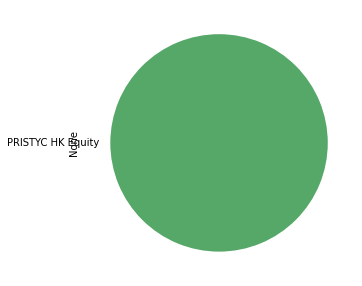

In [79]:
ef = EfficientFrontier(mu1, S1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 8.0%
Sharpe Ratio: 0.04


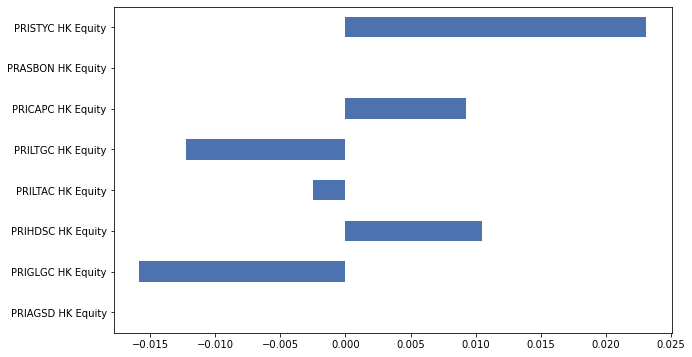

In [80]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
8.498448164436569
Portfolio return compared to train set (+- %):
6.186014875484279
Percentage change compared to train set (+- %):
267.5110631315561
-0.649
Compare to benchmark (+- %):
9.147448164436568


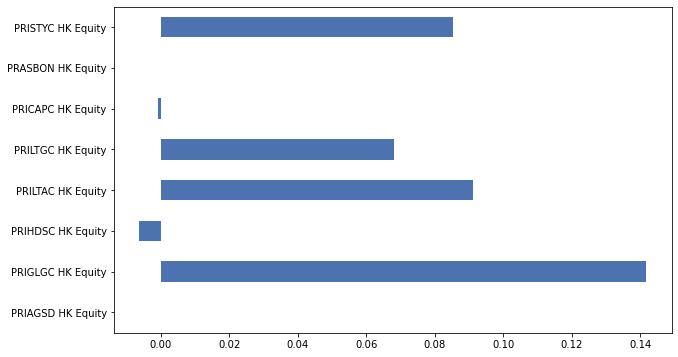

In [81]:
#calculate the asset returns in our portfolio.
ret_data = tone.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret1 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret1)*100)
print("Portfolio return compared to train set (+- %):")
diff1 = (sum(port_ret1) - ret)*100
print(diff1)
print("Percentage change compared to train set (+- %):")
perch1 = diff1/ret
print(perch1)
print(B1)
compare1=((sum(port_ret1)*100)-B1)
print("Compare to benchmark (+- %):")
print(compare1)

tmu1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 2nd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.46005), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.07405), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.4659)])
Performance of function 1a portfolio in train period:


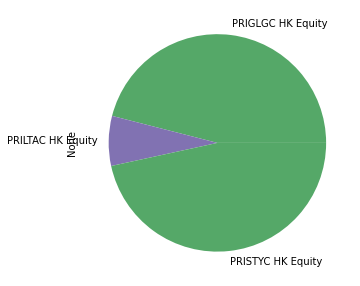

In [82]:
ef = EfficientFrontier(mu2, S2)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 6.7%
Annual volatility: 5.9%
Sharpe Ratio: 0.78


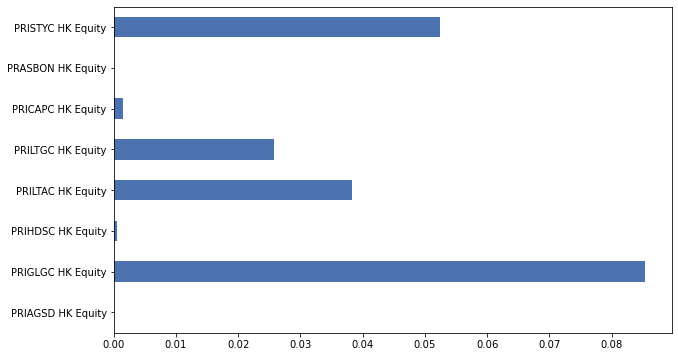

In [83]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu2.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
9.300984753528596
Portfolio return compared to train set (+- %):
2.6494192602590325
Percentage change compared to train set (+- %):
39.83151429449003
1.224
Compare to benchmark (+- %):
8.076984753528595


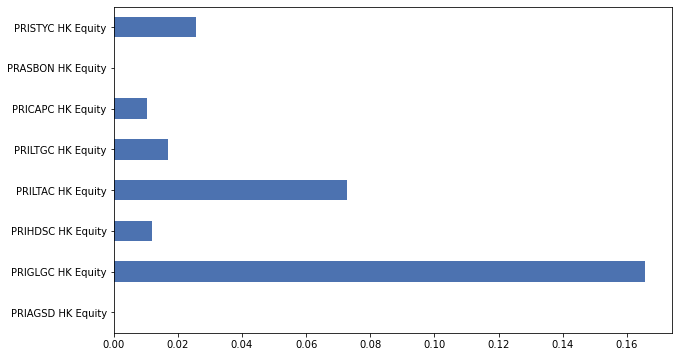

In [84]:
#calculate the asset returns in our portfolio.
ret_data = ttwo.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret2 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret2)*100)
print("Portfolio return compared to train set (+- %):")
diff2 = (sum(port_ret2) - ret)*100
print(diff2)
print("Percentage change compared to train set (+- %):")
perch2 = diff2/ret
print(perch2)
print(B2)
compare2=((sum(port_ret2)*100)-B2)
print("Compare to benchmark (+- %):")
print(compare2)

tmu2.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 3rd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.56002), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.06583), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37415)])
Performance of function 1a portfolio in train period:


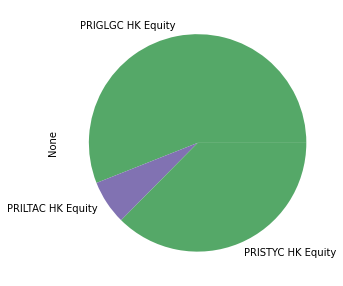

In [85]:
ef = EfficientFrontier(mu3, S3)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.7%
Annual volatility: 5.9%
Sharpe Ratio: 1.81


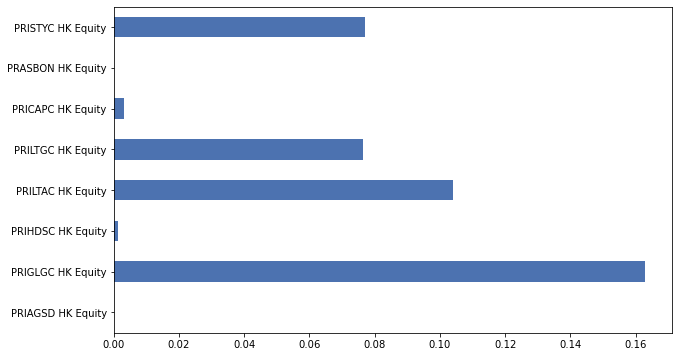

In [86]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu3.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
13.695884937643186
Portfolio return compared to train set (+- %):
1.0113179869175344
Percentage change compared to train set (+- %):
7.972822334779663
3.503
Compare to benchmark (+- %):
10.932884937643186


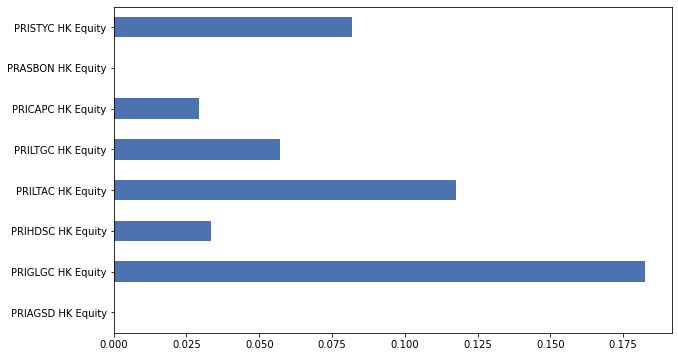

In [87]:
#calculate the asset returns in our portfolio.
ret_data = tthree.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret3 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret3)*100)
print("Portfolio return compared to train set (+- %):")
diff3 = (sum(port_ret3) - ret)*100
print(diff3)
print("Percentage change compared to train set (+- %):")
perch3 = diff3/ret
print(perch3)
print(B3)
compare3=((sum(port_ret3)*100)-B4)
print("Compare to benchmark (+- %):")
print(compare3)

tmu3.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 4th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.6386), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.02752), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.33388)])
Performance of function 1a portfolio in train period:


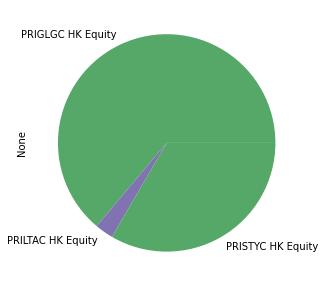

In [88]:
ef = EfficientFrontier(mu4, S4)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.9%
Annual volatility: 5.6%
Sharpe Ratio: 1.95


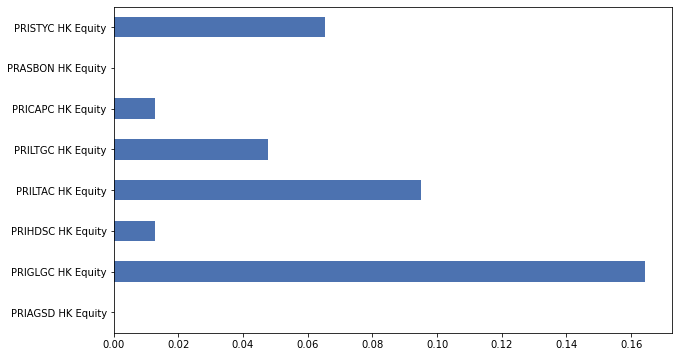

In [89]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu4.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
10.444929704436852
Portfolio return compared to train set (+- %):
-2.4894454345112687
Percentage change compared to train set (+- %):
-19.246739079145968
Compare to benchmark (+- %):
7.681929704436852


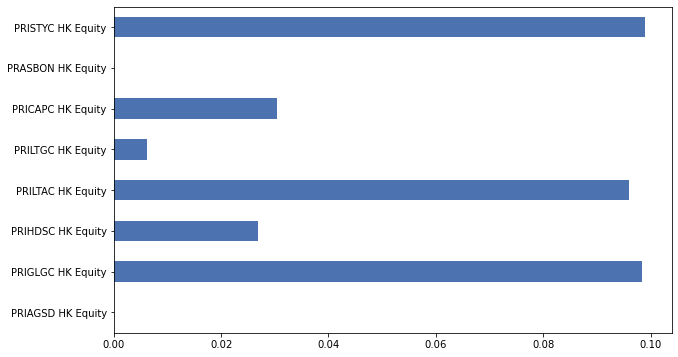

In [90]:
#calculate the asset returns in our portfolio.
ret_data = tfour.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret4 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret4)*100)
print("Portfolio return compared to train set (+- %):")
diff4 = (sum(port_ret4) - ret)*100
print(diff4)
print("Percentage change compared to train set (+- %):")
perch4 = diff4/ret
print(perch4)
compare4=((sum(port_ret4)*100)-B4)
print("Compare to benchmark (+- %):")
print(compare4)

tmu4.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 5th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.50291), ('PRIHDSC HK Equity', 0.06384), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.05338), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37987)])
Performance of function 1a portfolio in train period:


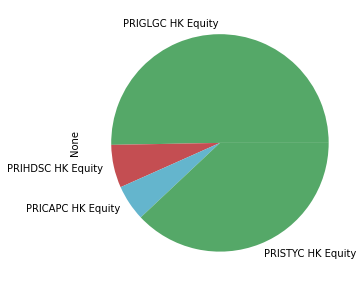

In [91]:
ef = EfficientFrontier(mu5, S5)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 10.5%
Annual volatility: 5.7%
Sharpe Ratio: 1.50


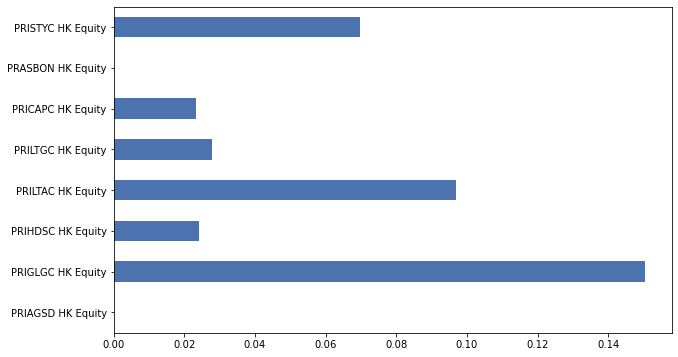

In [92]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu5.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-25.317949043814618
Portfolio return compared to train set (+- %):
-35.81006036442507
Percentage change compared to train set (+- %):
-341.30461706101653
Compare to benchmark (+- %):
-24.470949043814617


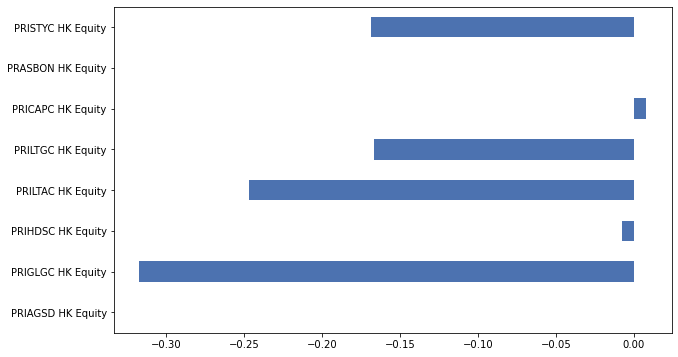

In [93]:
#calculate the asset returns in our portfolio.
ret_data = tfive.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret5 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret5)*100)
print("Portfolio return compared to train set (+- %):")
diff5 = (sum(port_ret5) - ret)*100
print(diff5)
print("Percentage change compared to train set (+- %):")
perch5 = diff5/ret
print(perch5)
compare5=((sum(port_ret5)*100)-B5)
print("Compare to benchmark (+- %):")
print(compare5)

tmu5.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 6th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 1.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


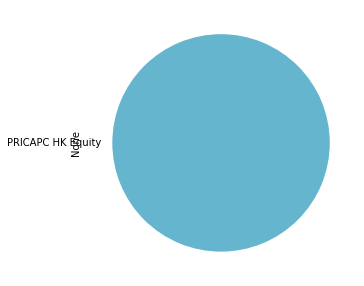

In [94]:
ef = EfficientFrontier(mu6, S6)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 0.9%
Sharpe Ratio: 0.29


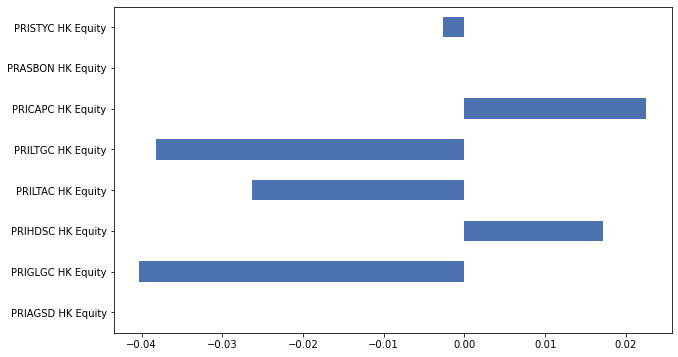

In [95]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu6.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
0.008037508359526324
Portfolio return compared to train set (+- %):
-2.2457873874636713
Percentage change compared to train set (+- %):
-99.64338363754781
Compare to benchmark (+- %):
0.08103750835952632


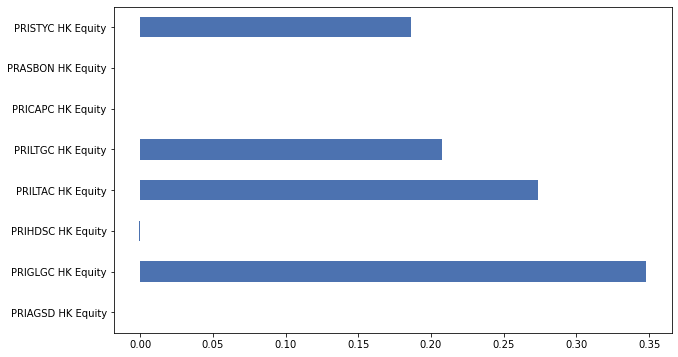

In [96]:
#calculate the asset returns in our portfolio.
ret_data = tsix.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret6 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret6)*100)
print("Portfolio return compared to train set (+- %):")
diff6 = (sum(port_ret6) - ret)*100
print(diff6)
print("Percentage change compared to train set (+- %):")
perch6 = diff6/ret
print(perch6)
compare6=((sum(port_ret6)*100)-B6)
print("Compare to benchmark (+- %):")
print(compare6)

tmu6.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 7th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 1.0)])
Performance of function 1a portfolio in train period:


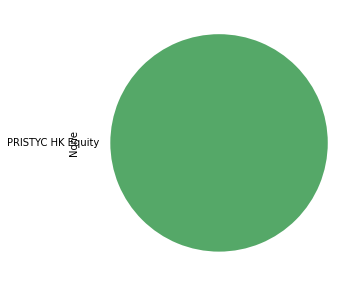

In [97]:
ef = EfficientFrontier(mu7, S7)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.9%
Annual volatility: 8.3%
Sharpe Ratio: 0.11


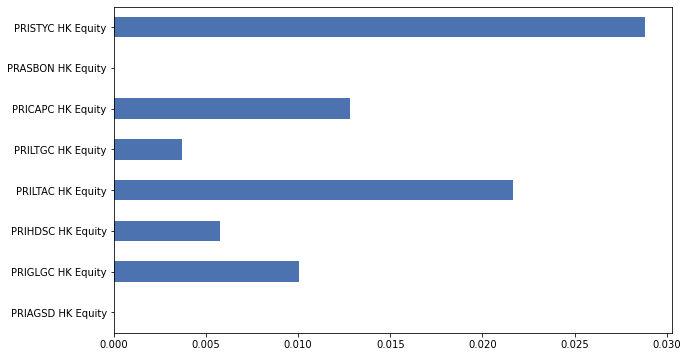

In [98]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu7.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
10.895408017751663
Portfolio return compared to train set (+- %):
8.013269455583426
Percentage change compared to train set (+- %):
278.03206829705783
Compare to benchmark (+- %):
11.480408017751664


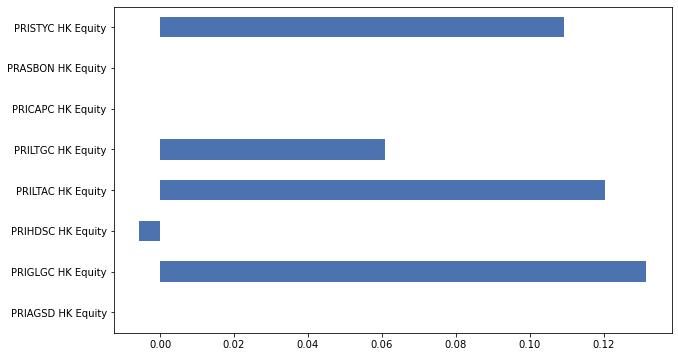

In [99]:
#calculate the asset returns in our portfolio.
ret_data = tseven.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret7 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret7)*100)
print("Portfolio return compared to train set (+- %):")
diff7 = (sum(port_ret7) - ret)*100
print(diff7)
print("Percentage change compared to train set (+- %):")
perch7 = diff7/ret
print(perch7)
compare7=((sum(port_ret7)*100)-B7)
print("Compare to benchmark (+- %):")
print(compare7)

tmu7.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 8th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.28566), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.71434)])
Performance of function 1a portfolio in train period:


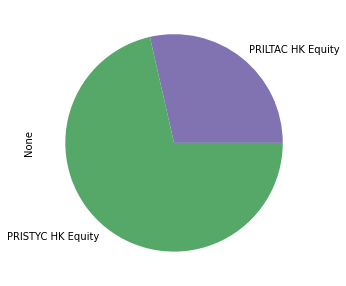

In [100]:
ef = EfficientFrontier(mu8, S8)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.0%
Annual volatility: 7.3%
Sharpe Ratio: 0.14


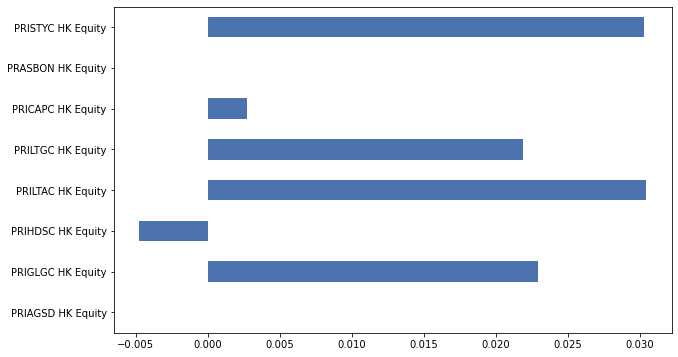

In [101]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu8.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

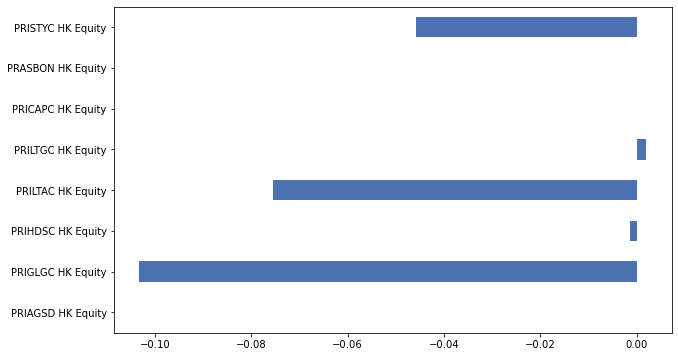

In [134]:
#calculate the asset returns in our portfolio.
ret_data = teight.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret8 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret8)*100)
print("Portfolio return compared to train set (+- %):")
diff8 = (sum(port_ret8) - ret)*100
print(diff9)
print("Percentage change compared to train set (+- %):")
perch8 = diff8/ret
print(perch8)
compare8=((sum(port_ret8)*100)-B8)
print("Compare to benchmark (+- %):")
print(compare8)

tmu8.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 9th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.86875), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.13125)])
Performance of function 1a portfolio in train period:


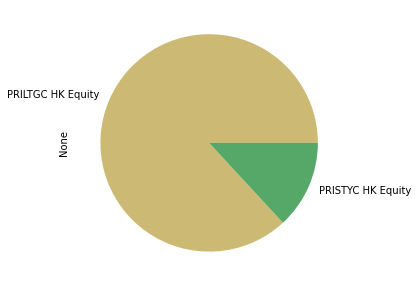

In [103]:
ef = EfficientFrontier(mu9, S9)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 8.5%
Annual volatility: 3.6%
Sharpe Ratio: 1.79


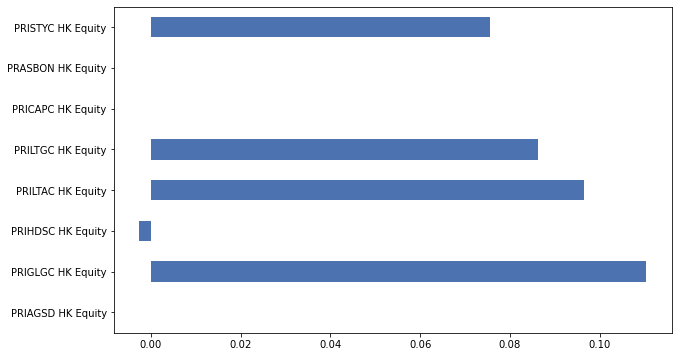

In [104]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu9.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
1.2441558299048818
Portfolio return compared to train set (+- %):
-7.242476371180497
Percentage change compared to train set (+- %):
-85.339816779785
Compare to benchmark (+- %):
0.8801558299048818


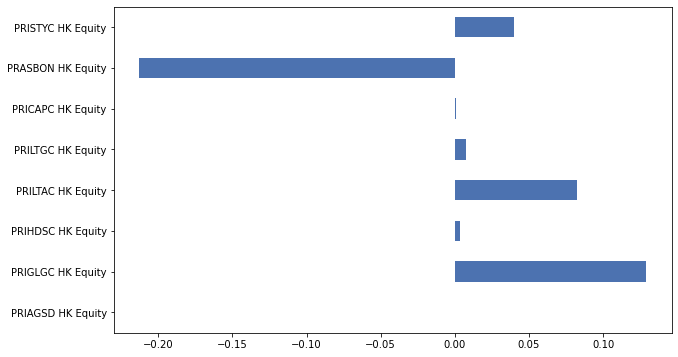

In [105]:
#calculate the asset returns in our portfolio.
ret_data = tnine.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret9 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret9)*100)
print("Portfolio return compared to train set (+- %):")
diff9 = (sum(port_ret9) - ret)*100
print(diff9)
print("Percentage change compared to train set (+- %):")
perch9 = diff9/ret
print(perch9)
compare9=((sum(port_ret9)*100)-B9)
print("Compare to benchmark (+- %):")
print(compare9)

tmu9.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 10th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.37949), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62051)])
Performance of function 1a portfolio in train period:


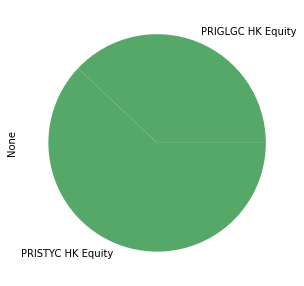

In [106]:
ef = EfficientFrontier(mu10, S10)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.6%
Annual volatility: 6.6%
Sharpe Ratio: 0.24


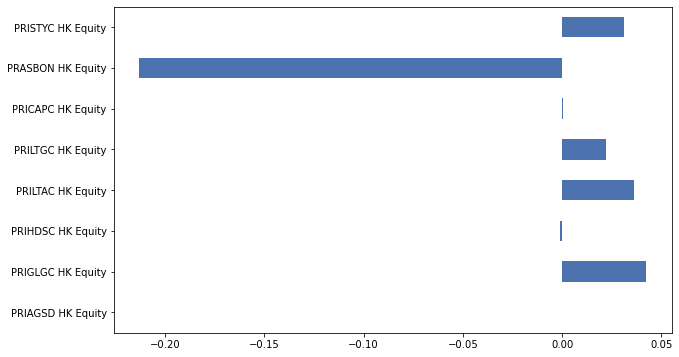

In [107]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu10.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
10.259611835469684
Portfolio return compared to train set (+- %):
6.703641566334382
Percentage change compared to train set (+- %):
188.51793066212824
Compare to benchmark (+- %):
10.215611835469684


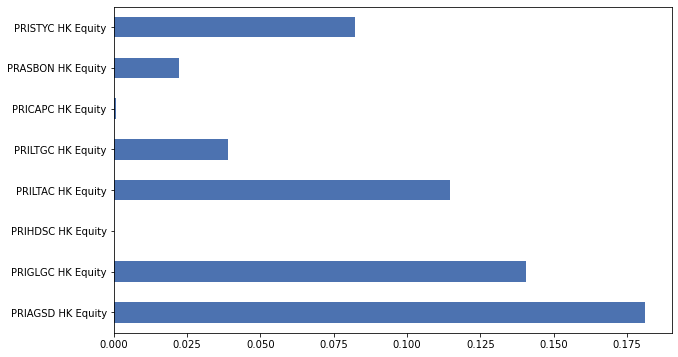

In [108]:
#calculate the asset returns in our portfolio.
ret_data = tten.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret10 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret10)*100)
print("Portfolio return compared to train set (+- %):")
diff10 = (sum(port_ret10) - ret)*100
print(diff10)
print("Percentage change compared to train set (+- %):")
perch10 = diff10/ret
print(perch10)
compare10=((sum(port_ret10)*100)-B10)
print("Compare to benchmark (+- %):")
print(compare10)

tmu10.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 11th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.99642), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.00358)])
Performance of function 1a portfolio in train period:


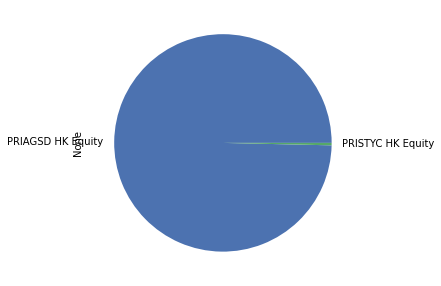

In [109]:
ef = EfficientFrontier(mu11, S11)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 18.1%
Annual volatility: 2.0%
Sharpe Ratio: 8.22


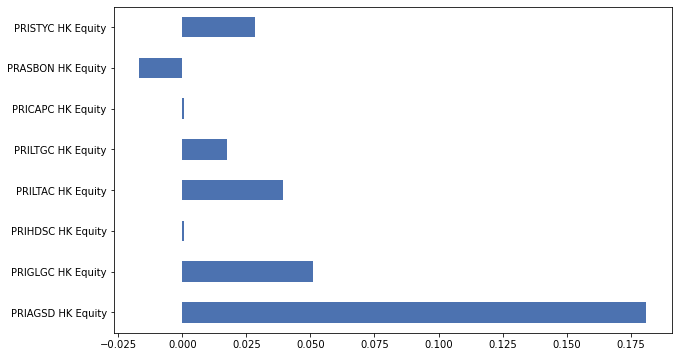

In [110]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu11.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
1.838073984619629
Portfolio return compared to train set (+- %):
-16.22208708010807
Percentage change compared to train set (+- %):
-89.82249395211946
Compare to benchmark (+- %):
1.464073984619629


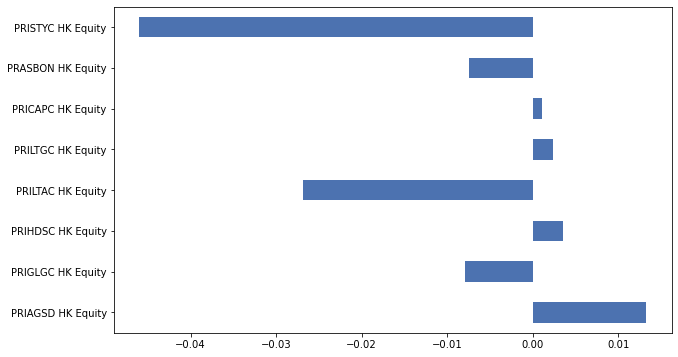

In [111]:
#calculate the asset returns in our portfolio.
ret_data = televen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret11 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret11)*100)
print("Portfolio return compared to train set (+- %):")
diff11 = (sum(port_ret11) - ret)*100
print(diff11)
print("Percentage change compared to train set (+- %):")
perch11 = diff11/ret
print(perch11)
compare11=((sum(port_ret11)*100)-B11)
print("Compare to benchmark (+- %):")
print(compare11)

tmu11.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 12th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.81216), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.18784)])
Performance of function 1a portfolio in train period:


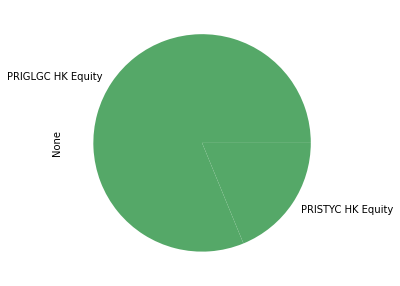

In [112]:
ef = EfficientFrontier(mu12, S12)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.2%
Annual volatility: 5.3%
Sharpe Ratio: 0.61


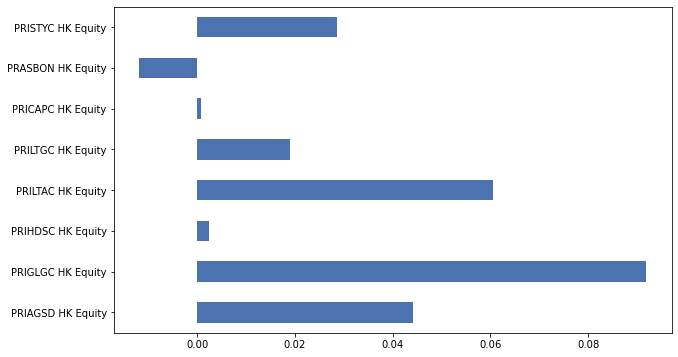

In [135]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu12.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-0.7229213351782496
Portfolio return compared to train set (+- %):
-8.723724787942157
Percentage change compared to train set (+- %):
-109.03560922907702
Compare to benchmark (+- %):
-0.3359213351782496


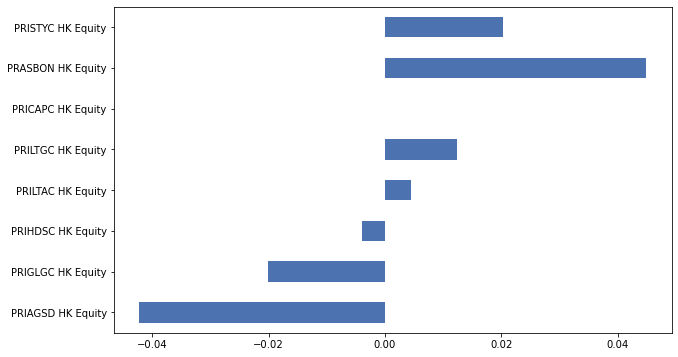

In [114]:
#calculate the asset returns in our portfolio.
ret_data = ttwelve.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret12 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret12)*100)
print("Portfolio return compared to train set (+- %):")
diff12 = (sum(port_ret12) - ret)*100
print(diff12)
print("Percentage change compared to train set (+- %):")
perch12 = diff12/ret
print(perch12)
compare12=(sum(port_ret12)*100)-B12
print("Compare to benchmark (+- %):")
print(compare12)

tmu12.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 13th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 1.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


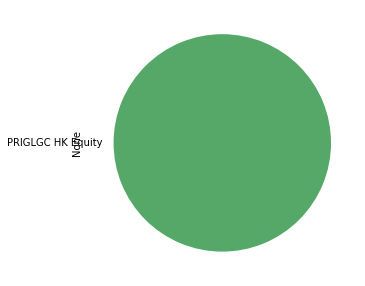

In [115]:
ef = EfficientFrontier(mu13, S13)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.4%
Annual volatility: 8.7%
Sharpe Ratio: 0.16


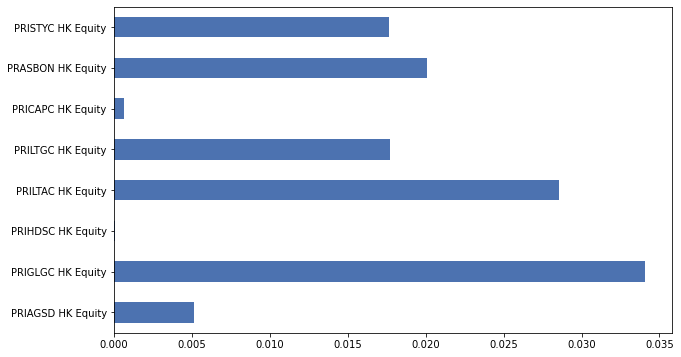

In [116]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu13.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
14.115149196321063
Portfolio return compared to train set (+- %):
10.707190636157948
Percentage change compared to train set (+- %):
314.18194931470845
Compare to benchmark (+- %):
13.820149196321063


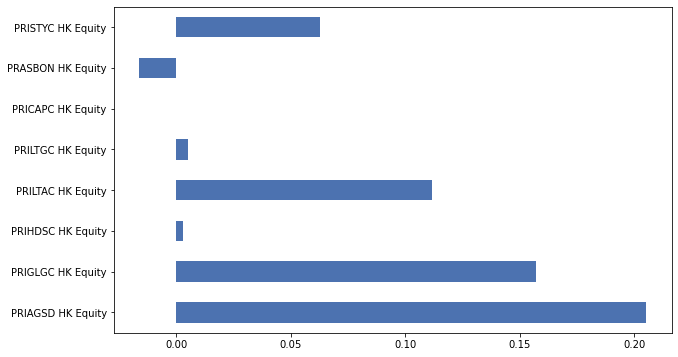

In [117]:
#calculate the asset returns in our portfolio.
ret_data = tthirteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret13 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret13)*100)
print("Portfolio return compared to train set (+- %):")
diff13 = (sum(port_ret13) - ret)*100
print(diff13)
print("Percentage change compared to train set (+- %):")
perch13 = diff13/ret
print(perch13)
compare13=((sum(port_ret13)*100)-B13)
print("Compare to benchmark (+- %):")
print(compare13)

tmu13.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 14th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 1.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


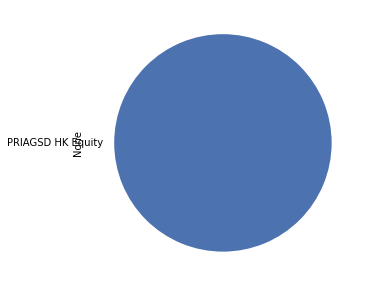

In [118]:
ef = EfficientFrontier(mu14, S14)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.8%
Annual volatility: 10.9%
Sharpe Ratio: 0.25


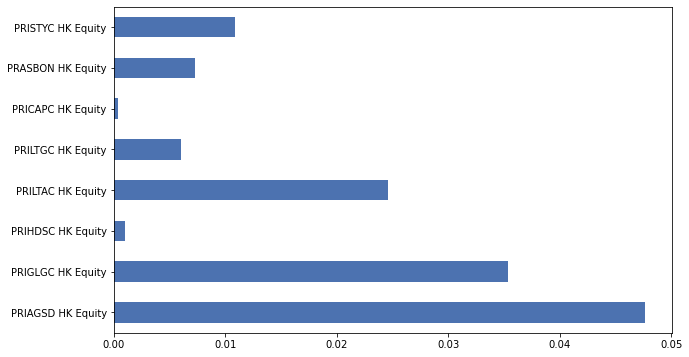

In [119]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu14.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
7.575767698219272
Portfolio return compared to train set (+- %):
2.811157209615678
Percentage change compared to train set (+- %):
59.00077700663352
Compare to benchmark (+- %):
1.3887676982192714


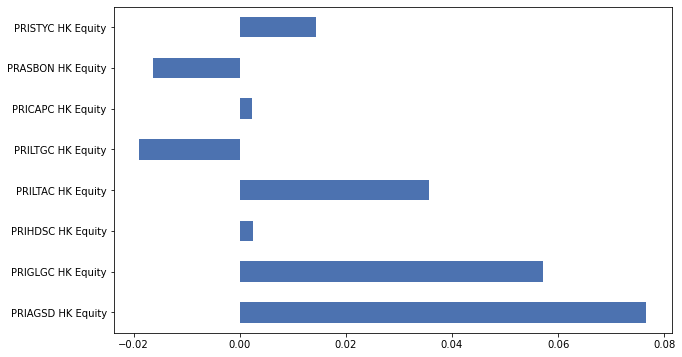

In [120]:
#calculate the asset returns in our portfolio.
ret_data = tfourteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret14 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret14)*100)
print("Portfolio return compared to train set (+- %):")
diff14 = (sum(port_ret14) - ret)*100
print(diff14)
print("Percentage change compared to train set (+- %):")
perch14 = diff14 /ret
print(perch14)
compare14=((sum(port_ret14)*100)-B14)
print("Compare to benchmark (+- %):")
print(compare14)

tmu14.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 15th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.37686), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62314)])
Performance of function 1a portfolio in train period:


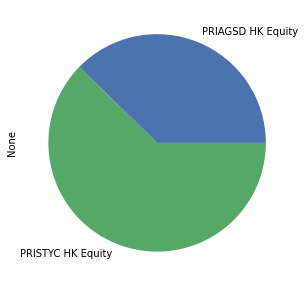

In [121]:
ef = EfficientFrontier(mu15, S15)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.9%
Annual volatility: 5.3%
Sharpe Ratio: 0.56


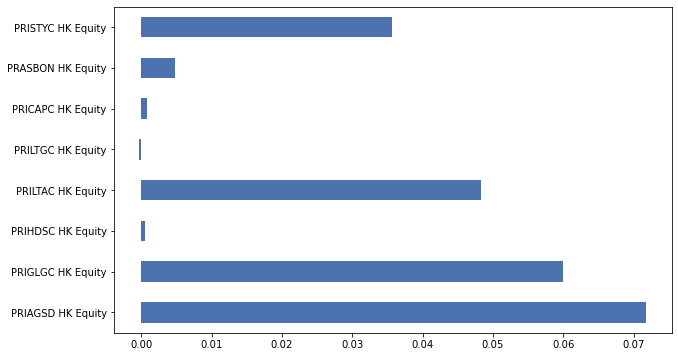

In [122]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu15.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-0.1112885293017936
Portfolio return compared to train set (+- %):
-5.040929777002809
Percentage change compared to train set (+- %):
-102.2575380988159
Compare to benchmark (+- %):
-3.3202885293017936


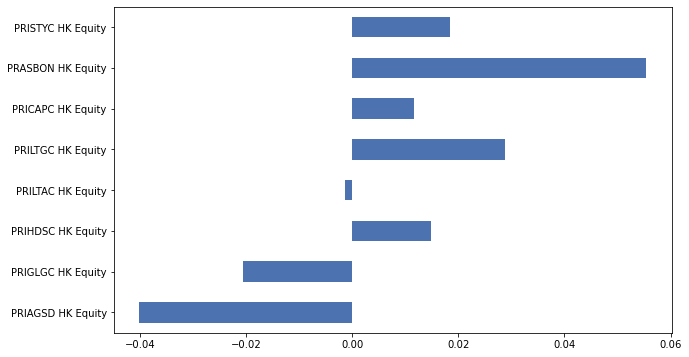

In [123]:
#calculate the asset returns in our portfolio.
ret_data = tfifteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret15 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret15)*100)
print("Portfolio return compared to train set (+- %):")
diff15 = (sum(port_ret15) - ret)*100
print(diff15)
print("Percentage change compared to train set (+- %):")
perch15 = diff15/ret
print(perch15)
compare15=((sum(port_ret15)*100)-B15)
print("Compare to benchmark (+- %):")
print(compare15)

tmu15.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 16th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.49936), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.50064)])
Performance of function 1a portfolio in train period:


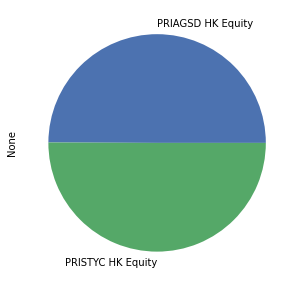

In [124]:
ef = EfficientFrontier(mu16, S16)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.2%
Annual volatility: 5.3%
Sharpe Ratio: 0.61


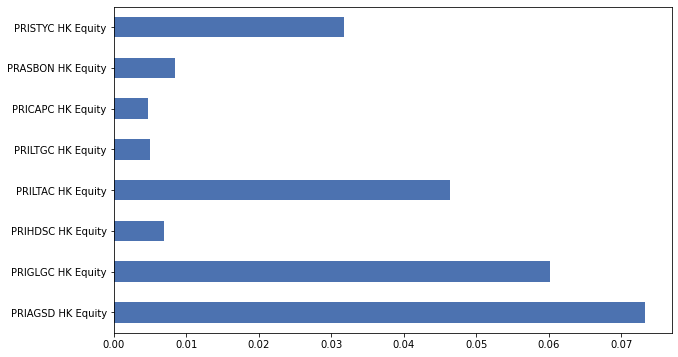

In [125]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu16.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
6.731148598849307
Portfolio return compared to train set (+- %):
1.4827108191189917
Percentage change compared to train set (+- %):
28.25051722715057
Compare to benchmark (+- %):
0.07114859884930702


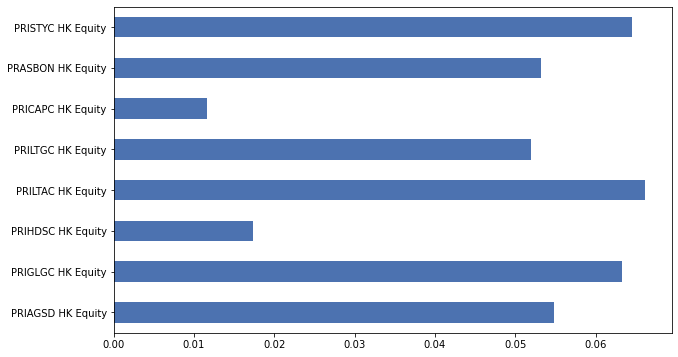

In [126]:
#calculate the asset returns in our portfolio.
ret_data = tsixteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret16 = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret16)*100)
print("Portfolio return compared to train set (+- %):")
diff16 = (sum(port_ret16) - ret)*100
print(diff16)
print("Percentage change compared to train set (+- %):")
perch16 = diff16/ret
print(perch16)
compare16=((sum(port_ret16)*100)-B16)
print("Compare to benchmark (+- %):")
print(compare16)

tmu16.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

## Summary of Backtesting of Function 1a

In [127]:
perch_all = [perch12,perch13,perch14,perch15,perch16]
compare_all = [compare12,compare13,compare14,compare15,compare16]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret12))*(1+sum(port_ret13))*(1+sum(port_ret14))*(1+sum(port_ret15))*(1+sum(port_ret16))-1)*100
benchmark = ((1+B12/100)*(1+B13/100)*(1+B14/100)*(1+B15/100)*(1+B16/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): 38.02801924411993
Function 1a Average return compare to Benchmark(%): 2.3247711257819197
Return Overall(%): 29.931466313638744
Benchmark Overall(%): 16.784660679940643


In [128]:
perch_all = [perch7,perch8,perch9,perch10,perch11,perch12,perch13,perch14,perch15,perch16]
compare_all = [compare7,compare8,compare9,compare10,compare11,compare12,compare13,compare14,compare15,compare16]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret7))*(1+sum(port_ret8))*(1+sum(port_ret9))*(1+sum(port_ret10))*(1+sum(port_ret11))*(1+sum(port_ret12))*(1+sum(port_ret13))*(1+sum(port_ret14))*(1+sum(port_ret15))*(1+sum(port_ret16))-1)*100
benchmark = ((1+B7/100)*(1+B8/100)*(1+B9/100)*(1+B10/100)*(1+B11/100)*(1+B12/100)*(1+B13/100)*(1+B14/100)*(1+B15/100)*(1+B16/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): 20.527933560462152
Function 1a Average return compare to Benchmark(%): 3.046961495306751
Return Overall(%): 55.04951101633764
Benchmark Overall(%): 16.835825159467266


In [129]:
perch_all = [perch1,perch2,perch3,perch4,perch5]
compare_all = [compare1,compare2,compare3,compare4,compare5]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret1))*(1+sum(port_ret2))*(1+sum(port_ret3))*(1+sum(port_ret4))*(1+sum(port_ret5))-1)*100
benchmark = ((1+B1/100)*(1+B2/100)*(1+B3/100)*(1+B4/100)*(1+B5/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): -9.04719127586734
Function 1a Average return compare to Benchmark(%): 2.2736597032461168
Return Overall(%): 11.212695499803838
Benchmark Overall(%): 6.059923333425643


In [130]:
perch_all = [perch6,perch7,perch8,perch9,perch10]
compare_all = [compare6,compare7,compare8,compare9,compare10]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret6))*(1+sum(port_ret7))*(1+sum(port_ret8))*(1+sum(port_ret9))*(1+sum(port_ret10))-1)*100
benchmark = ((1+B6/100)*(1+B7/100)*(1+B8/100)*(1+B9/100)*(1+B10/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))


Function 1a Average error (%): 1.0636699397187102
Function 1a Average return compare to Benchmark(%): 3.4925445695795623
Return Overall(%): 17.187365040719182
Benchmark Overall(%): -0.401718595693612


In [131]:
perch_all = [perch1,perch2,perch3,perch4,perch5,perch6,perch7,perch8,perch9,perch10]
compare_all = [compare1,compare2,compare3,compare4,compare5,compare6,compare7,compare8,compare9,compare10]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret1))*(1+sum(port_ret2))*(1+sum(port_ret3))*(1+sum(port_ret4))*(1+sum(port_ret5))*(1+sum(port_ret6))*(1+sum(port_ret7))*(1+sum(port_ret8))*(1+sum(port_ret9))*(1+sum(port_ret10))-1)*100
benchmark = ((1+B1/100)*(1+B2/100)*(1+B3/100)*(1+B4/100)*(1+B5/100)*(1+B6/100)*(1+B7/100)*(1+B8/100)*(1+B9/100)*(1+B10/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))


Function 1a Average error (%): -3.9917606680743147
Function 1a Average return compare to Benchmark(%): 2.8831021364128397
Return Overall(%): 30.327227446978622
Benchmark Overall(%): 5.633860898816856


In [132]:
perch_all = [perch1,perch2,perch3,perch4,perch5,perch6,perch7,perch8,perch9,perch10,perch11,perch12,perch13,perch14,perch15,perch16]
compare_all = [compare1,compare2,compare3,compare4,compare5,compare6,compare7,compare8,compare9,compare10,compare11,compare12,compare13,compare14,compare15,compare16]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret1))*(1+sum(port_ret2))*(1+sum(port_ret3))*(1+sum(port_ret4))*(1+sum(port_ret5))*(1+sum(port_ret6))*(1+sum(port_ret7))*(1+sum(port_ret8))*(1+sum(port_ret9))*(1+sum(port_ret10))*(1+sum(port_ret11))*(1+sum(port_ret12))*(1+sum(port_ret13))*(1+sum(port_ret14))*(1+sum(port_ret15))*(1+sum(port_ret16))-1)*100
benchmark = ((1+B1/100)*(1+B2/100)*(1+B3/100)*(1+B4/100)*(1+B5/100)*(1+B6/100)*(1+B7/100)*(1+B8/100)*(1+B9/100)*(1+B10/100)*(1+B11/100)*(1+B12/100)*(1+B13/100)*(1+B14/100)*(1+B15/100)*(1+B16/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): 3.774999724233563
Function 1a Average return compare to Benchmark(%): 2.6199344361036014
Return Overall(%): 72.44860001722174
Benchmark Overall(%): 23.825527919895407


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 1b - Long/short min variance
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

OrderedDict([('PRIAGSD HK Equity', 0.20382), ('PRIGLGC HK Equity', 0.04955), ('PRIHDSC HK Equity', 0.18541), ('PRILTAC HK Equity', 0.02463), ('PRILTGC HK Equity', 0.01249), ('PRICAPC HK Equity', 0.20387), ('PRASBON HK Equity', 0.20382), ('PRISTYC HK Equity', 0.1164)])
Expected annual return: 0.6%
Annual volatility: 2.6%
Sharpe Ratio: -0.56


Text(0.5, 1.0, 'Fund Portfolio')

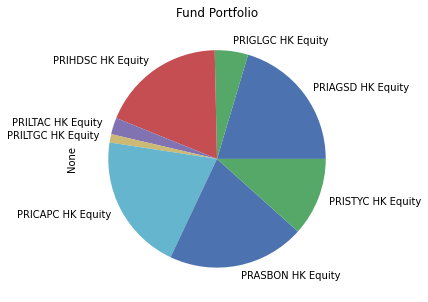

In [100]:
ef = EfficientFrontier(mu1, S1)

ef.min_volatility() #input desired volatility - default as ten percent
cleanweight2b = ef.clean_weights()
print(cleanweight2b)

ret,vol,sharpe = ef.portfolio_performance(verbose=True)


pd.Series(cleanweight2b).plot.pie(figsize=(5,5))
plt.title("Fund Portfolio")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 2- Portfolio Optimization with given Risk Tolerance
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.24216), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.17525), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.58258)])
Expected annual return: 1.8%
Annual volatility: 5.0%
Sharpe Ratio: -0.05


Text(0.5, 1.0, 'Fund Portfolio')

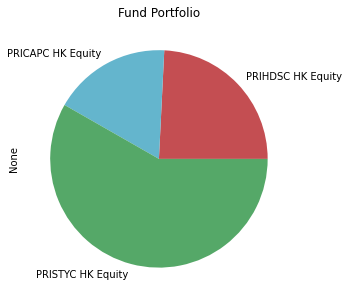

In [105]:
ef = EfficientFrontier(mu1, S1)

ef.efficient_risk(target_volatility=0.05) #input desired volatility - default as ten percent
cleanweight2a = ef.clean_weights()
print(cleanweight2a)

ret,vol,sharpe = ef.portfolio_performance(verbose=True)


pd.Series(cleanweight2a).plot.pie(figsize=(5,5))
plt.title("Fund Portfolio")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 3 - Minimise risk for a given return
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

In [103]:
ef = EfficientFrontier(mu1, S1, weight_bounds=(None, None))
ef.efficient_return(target_return=0.02, market_neutral=True)
cleanweight3 = ef.clean_weights()
print(cleanweight3)

OrderedDict([('PRIAGSD HK Equity', -0.28), ('PRIGLGC HK Equity', -0.25242), ('PRIHDSC HK Equity', 0.22225), ('PRILTAC HK Equity', 0.19365), ('PRILTGC HK Equity', -0.21455), ('PRICAPC HK Equity', 0.18793), ('PRASBON HK Equity', -0.28), ('PRISTYC HK Equity', 0.42313)])


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Plotting Efficient Frontier

In [64]:
from pypfopt import CLA, plotting

cla = CLA(mu1, S1)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 1.5%
Annual volatility: 3.9%
Sharpe Ratio: -0.14


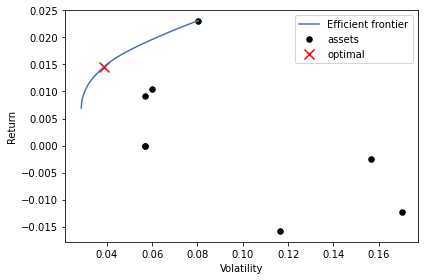

In [65]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# This scheme in a nutshell:

##         Any portfolio with volatility higher than 11.1% is bad because you earn the same afterwards. The highest return you can get is 5.0%.

In [66]:
risktolerance, annualreturn = [], []
for rt2 in np.arange(0.02, 1, 0.001):
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(target_volatility=rt2)
    weights = ef.clean_weights()
    ret, volatility, Sharpe = ef.portfolio_performance(verbose=True)
    annualreturn.append(ret)
    risktolerance.append(rt2)


Expected annual return: 2.0%
Annual volatility: 2.0%
Sharpe Ratio: -0.02
Expected annual return: 2.0%
Annual volatility: 2.1%
Sharpe Ratio: 0.02
Expected annual return: 2.1%
Annual volatility: 2.2%
Sharpe Ratio: 0.05
Expected annual return: 2.2%
Annual volatility: 2.3%
Sharpe Ratio: 0.08
Expected annual return: 2.3%
Annual volatility: 2.4%
Sharpe Ratio: 0.11
Expected annual return: 2.3%
Annual volatility: 2.5%
Sharpe Ratio: 0.13
Expected annual return: 2.4%
Annual volatility: 2.6%
Sharpe Ratio: 0.15
Expected annual return: 2.5%
Annual volatility: 2.7%
Sharpe Ratio: 0.18
Expected annual return: 2.5%
Annual volatility: 2.8%
Sharpe Ratio: 0.19
Expected annual return: 2.6%
Annual volatility: 2.9%
Sharpe Ratio: 0.21
Expected annual return: 2.7%
Annual volatility: 3.0%
Sharpe Ratio: 0.23
Expected annual return: 2.8%
Annual volatility: 3.1%
Sharpe Ratio: 0.24
Expected annual return: 2.8%
Annual volatility: 3.2%
Sharpe Ratio: 0.26
Expected annual return: 2.9%
Annual volatility: 3.3%
Sharpe Rat

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expecte

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

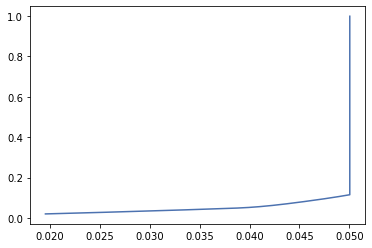

In [67]:
plt.plot(annualreturn, risktolerance)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [61]:
perch_all = [perch1,perch2,perch3,perch4,perch5,perch6,perch7,perch8,perch9,perch10,perch11,perch12,perch13,perch14,perch15,perch16]
compare_all = [compare1,compare2,compare3,compare4,compare5,compare6,compare7,compare8,compare9,compare10,compare11,compare12,compare13,compare14,compare15,compare16]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
overall = ((1+sum(port_ret1))*(1+sum(port_ret2))*(1+sum(port_ret3))*(1+sum(port_ret4))*(1+sum(port_ret5))*(1+sum(port_ret6))*(1+sum(port_ret7))*(1+sum(port_ret8))*(1+sum(port_ret9))*(1+sum(port_ret10))*(1+sum(port_ret11))*(1+sum(port_ret12))*(1+sum(port_ret13))*(1+sum(port_ret14))*(1+sum(port_ret15))*(1+sum(port_ret16))-1)*100
benchmark = ((1+B1/100)*(1+B2/100)*(1+B3/100)*(1+B4/100)*(1+B5/100)*(1+B6/100)*(1+B7/100)*(1+B8/100)*(1+B9/100)*(1+B10/100)*(1+B11/100)*(1+B12/100)*(1+B13/100)*(1+B14/100)*(1+B15/100)*(1+B16/100)-1)*100

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
print( "Return Overall(%): " + str(overall))
print( "Benchmark Overall(%): " + str(benchmark))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): 3.7750335038429235
Function 1a Average return compare to Benchmark(%): 2.6199344361036014
Return Overall(%): 72.44860001722174
Benchmark Overall(%): 23.825527919895407
